## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I worked through the results of an A/B test ran by an e-commerce website. My goal was to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` a. Read in the dataset 

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Used the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [8]:
no_match = 1965 + 1928
no_match

3893

f. Identify missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Removed these rows 

In [10]:
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. Unique **user_id**s in **df2**

In [12]:
df2['user_id'].nunique()

290584

b. Repeated **user_id** in **df2**

In [13]:
df2[df2.duplicated(subset = 'user_id', keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. Row information for the repeat **user_id**.  

In [14]:
df2[df2.duplicated(subset = 'user_id', keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removed **one** of the rows with a duplicate **user_id**. 

In [15]:
df2 = df2.drop_duplicates(subset = 'user_id', keep = 'last')

`4.` a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2[df2['landing_page'] == 'new_page'].count() / df2['landing_page'].count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider results from parts (a) through (d) above, is there sufficient evidence to conclude that the new treatment page leads to more conversions?

**The probability of an individual converting given he received the old page is only 0.0016 more than that of an individual who received the new page. We would have to test whether this result is statistically significant. Nevertheless, it does not seem the results will be practically significant.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

                      H0: p_old ≥ p_new
                      H1: p_old ≤ p_new

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Used a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performed the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating and estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2['group'] == 'treatment']['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2['group'] == 'control']['user_id'].count()
n_old

145274

e. Simulated $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null. 

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_new)
treatment_sim = new_page_converted.mean()
treatment_sim

0.11990915972747919

f. Simulated $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null. 

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)
control_sim = old_page_converted.mean()
control_sim

0.11869983617164806

g. Found $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [26]:
sim_diff = treatment_sim - control_sim
sim_diff

0.0012093235558311294

h. Created 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Stored all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
for i in range(10000):
    old_page_converted = np.random.binomial(1, p_old, n_old)
    b_control = old_page_converted.mean()
    new_page_converted = np.random.binomial(1, p_new, n_new)
    b_treatment = new_page_converted.mean()
    p_diffs.append(b_treatment - b_control)

i. Plotted a histogram of the **p_diffs**.

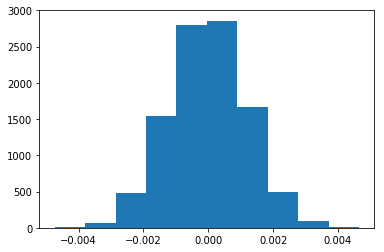

In [28]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
control = df2[df2['group'] == 'control'].converted.mean()
treatment = df2[df2['group'] == 'treatment'].converted.mean()
obs_diff = treatment - control
obs_diff

-0.0015782389853555567

In [30]:
(p_diffs > obs_diff).mean() #p-value

0.9032

k. What does this value mean in terms of whether or not there is a difference between the new and old pages?

**0.91 is the p-value. This is basically showing us that there is a 91% probability that our statistic comes from the null, meaning that we fail to reject the null hypothesis and we establish that the old page is indeed better or as good as the new page in pushing convertions.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [42]:
convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()

m. Used `stats.proportions_ztest` to compute  test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [43]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The computed z-score does not exceed the critical value of our 95% confidence interval and for this reason we would fail to reject the null hypothesis. Additionally, the computed p-value is the same as in our previous results so we have even more reason to fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` Results achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. What type of regression should you we perform in this case?

**Given the dependent variable (conversion) is binary in nature, we should perform a Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  

In [32]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Used **statsmodels** to instantiate regression model on the two columns  created in part b., then fitted the model using the two columns  created in part **b.** to predict whether or not an individual converts. 

In [33]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of  model below.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        06:19:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**The p-value associated with ab_page is 0.190, because it is above our α level of 0.05 we fail to reject the null hypothesis. The p-value (0.190) differs from that of Part II (0.91) because we are performing different kind of tests. In Part II we are performing a hypothesis test to study whether one group is better or as good as the other, whereas in the logistic regression we are studying whether a relationship between two variables (ab_page & converted) is significant or not.**

f. Other things that might influence whether or not an individual converts. Is it a good idea to consider other factors to add into regression model.  Are there any disadvantages to adding additional terms into regression model?

**Pros: Studying more variables might allow us to identify new factors influencing convertion /                     Cons: Multicollinearity might arise from adding more variables, undermining the statistical significance of our independent variables**

g. Added an effect based on which country a user lives in. [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

In [35]:
df_countries = pd.read_csv('countries.csv')
df3 = df_countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [36]:
df3['country'].unique() #check how many countries are in the dataset 

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
df3[['UK', 'US', 'CA']] = pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,UK,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [38]:
log_mod = sm.Logit(df3['converted'], df3[['intercept','UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:               1.521e-05
Time:                        06:19:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

h. Looked at the interaction between page and country to see if there significant effects on conversion.

In [45]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        06:28:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

***Even after accounting for countries to our model there is no change in the statistical signifcance of the variables. For this reason it would be advisable for the company to not implement the new_page as it seems the old_page is better at converting.***

In [39]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0